In [31]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/pre_ADA-USD.csv')
df = df.rename(columns={'Close': 'Price'})
df['Date'] = pd.to_datetime(df['Date'])
df.head(5)

,Date,Open,High,Low,Price,Adj Close,Volume
0,2018-03-01,0.311973,0.311973,0.288392,0.304397,0.304397,184691008
1,2018-03-02,0.304424,0.307058,0.288875,0.293504,0.293504,107240000
2,2018-03-03,0.292952,0.309129,0.292507,0.297106,0.297106,115320000
3,2018-03-04,0.296285,0.303588,0.286193,0.300787,0.300787,94436000
4,2018-03-05,0.299897,0.317723,0.291055,0.297622,0.297622,202675008


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2285 entries, 0 to 2284
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2285 non-null   datetime64[ns]
 1   Open       2285 non-null   float64       
 2   High       2285 non-null   float64       
 3   Low        2285 non-null   float64       
 4   Price      2285 non-null   float64       
 5   Adj Close  2285 non-null   float64       
 6   Volume     2285 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 125.1 KB


In [34]:
# Thiết lập index
df1=df.reset_index()['Price']


In [61]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [62]:
# Chia train test
train_size= int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [63]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - time_step - 1):
		a = dataset[i:(i + time_step)]
		dataX.append(a)
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)


In [64]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100 _8_2
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
combined_data = np.concatenate((train_data[-time_step:], test_data))
X_test, y_test = create_dataset(combined_data, time_step)

# Reshape dữ liệu cho phù hợp với mạng GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [65]:
# Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [73]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
31/31 [==============================] - 2s 77ms/step - loss: 2.5775e-04
Epoch 2/100
31/31 [==============================] - 2s 55ms/step - loss: 2.6672e-04
Epoch 3/100
31/31 [==============================] - 2s 52ms/step - loss: 2.7346e-04
Epoch 4/100
31/31 [==============================] - 2s 53ms/step - loss: 2.5467e-04
Epoch 5/100
31/31 [==============================] - 2s 52ms/step - loss: 2.4865e-04
Epoch 6/100
31/31 [==============================] - 2s 64ms/step - loss: 2.4891e-04
Epoch 7/100
31/31 [==============================] - 3s 84ms/step - loss: 2.4766e-04
Epoch 8/100
31/31 [==============================] - 3s 99ms/step - loss: 2.5285e-04
Epoch 9/100
31/31 [==============================] - 2s 61ms/step - loss: 2.5764e-04
Epoch 10/100
31/31 [==============================] - 2s 61ms/step - loss: 2.5362e-04
Epoch 11/100
31/31 [==============================] - 2s 60ms/step - loss: 2.5407e-04
Epoch 12/100
31/31 [==============================] - 2s 54ms/s

In [74]:
# Dự báo dữ liệu test và train
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

8/8 [==============================] - 0s 11ms/step


In [75]:
# Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [76]:
# Dự báo 90 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

i = 0
while(i < 90):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])  # Lấy từng ngày từ ngày thứ 2 trở đi
        x_input = x_input.reshape(1, time_step, 1)  # Reshape lại để phù hợp với input của mạng
        yhat = model.predict(x_input, verbose=0)  # Dự đoán giá cho ngày tiếp theo
        temp_input.extend(yhat[0].tolist())  # Thêm dự đoán vào danh sách temp_input
        temp_input = temp_input[1:]  # Loại bỏ ngày đầu tiên
        lst_output.extend(yhat.tolist())  # Lưu dự đoán vào mảng lst_output
        i += 1
    else:
        x_input = x_input.reshape(1, time_step, 1)  # Reshape lại để phù hợp với input của mạng
        yhat = model.predict(x_input, verbose=0)  # Dự đoán giá cho ngày tiếp theo
        temp_input.extend(yhat[0].tolist())  # Thêm dự đoán vào danh sách temp_input
        lst_output.extend(yhat.tolist())  # Lưu dự đoán vào mảng lst_output
        i += 1

# In ra dự đoán cho 90 ngày tiếp theo
print("Dự đoán giá cho 90 ngày tiếp theo:")
print(lst_output)

Dự đoán giá cho 90 ngày tiếp theo:
[[0.14094659686088562], [0.13781915605068207], [0.13450241088867188], [0.13141141831874847], [0.12813712656497955], [0.12484973669052124], [0.12150014936923981], [0.11811111867427826], [0.11468080431222916], [0.11121321469545364], [0.10770948231220245], [0.10417073220014572], [0.1005975753068924], [0.09699038416147232], [0.09334930032491684], [0.08967435359954834], [0.08596543222665787], [0.0822223648428917], [0.0784449428319931], [0.07463287562131882], [0.07078585773706436], [0.06690352410078049], [0.06298552453517914], [0.05903145298361778], [0.05504092946648598], [0.0510135255753994], [0.04694882780313492], [0.042846400290727615], [0.03870580345392227], [0.034526582807302475], [0.030308306217193604], [0.026050502434372902], [0.021752726286649704], [0.017414508387446404], [0.013035397976636887], [0.008614926598966122], [0.004152633715420961], [-0.000351946335285902], [-0.00489927688613534], [-0.009489817544817924], [-0.014124024659395218], [-0.01880

In [77]:
predict_future_30 = lst_output[:30]
predict_future_60 = lst_output[30:60]
predict_future_90 = lst_output[60:]


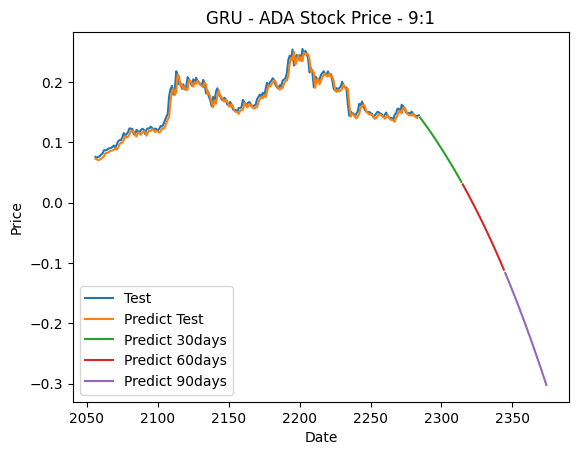

In [78]:
#Vẽ hình
# train_data_index = pd.RangeIndex(start=0, stop=len(train_data), step=1)
# plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+len(test_data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

predicted_test_index = pd.RangeIndex(start=train_size, stop=train_size+len(y_pred), step=1)
plt.plot(predicted_test_index, y_pred)

predict_future_30_index = pd.RangeIndex(start=test_data_index[-1]+1, stop=test_data_index[-1]+31, step=1)
plt.plot(predict_future_30_index, scaler.inverse_transform(predict_future_30))

predict_future_60_index = pd.RangeIndex(start=test_data_index[-1]+31, stop=test_data_index[-1]+61, step=1)
plt.plot(predict_future_60_index, scaler.inverse_transform(predict_future_60))

predict_future_90_index = pd.RangeIndex(start=test_data_index[-1]+61, stop=test_data_index[-1]+91, step=1)
plt.plot(predict_future_90_index, scaler.inverse_transform(predict_future_90))

plt.title('GRU - ADA Stock Price - 9:1')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Test','Predict Test','Predict 30days','Predict 60days','Predict 90days'])
plt.show()

In [57]:
# y_test = scaler.inverse_transform(y_test.reshape(-1,1))
# y_test

In [79]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape * 100)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.006519344621243477
Mean Absolute Percentage Error (MAPE): 4.034722358031993
Root Mean Square Error (RMSE): 0.008717502697772545


In [ ]:
# # 12. Đánh giá độ chính xác thuật toán bằng RMSE
# test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
# print('Testing RMSE:', test_rmse)
# # Đánh giá độ chính xác thuật toán bằng MAE
# test_mae = np.mean(abs(y_pred - y_test))
# print('Testing MAE:', test_mae)
# # Đánh giá độ chính xác thuật toán bằng MAPE
# test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_pred))
# print('Testing MAPE:', test_mape)

Testing RMSE: 0.30995897321254945
Testing MAE: 0.29635483355720177
Testing MAPE: 0.6935905549176788
